# 3D *tobac* Tutorial: Gridded Radar Data

This tutorial will demonstrate how to use *tobac* to detect and track convection with gridded radar data. Because this tutorial uses 3D feature detection, you must use the v1.5 (3D and PBC changes) of *tobac*. 


This tutorial requires the use of pre-gridded radar data, which is available for download at a Zenodo link:

In [1]:
%matplotlib inline

Note that this tutorial also requires Py-ART to grid the radar data.

#### Imports

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import pyart
import glob
import datetime
import matplotlib.gridspec as gridspec
import pandas as pd
import os
import math
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [3]:
path ="/Users/kelcy/DATA/20080411/"
#Download data from the following location: 10.5281/zenodo.8148589

### Load and Preprocess Data

In [12]:
# Read the data that is in antenna coordinates for all radars
all_radar_gridded = dict()
for radar_file_name in sorted(glob.glob(path+"*.nc")):
    radar_time_str = radar_file_name.split('_')[-2]#[:-3]
    radar_time  = datetime.datetime.strptime(radar_time_str, '%Y%m%d%H%M%S')
    all_radar_gridded[radar_time] = pyart.io.read_grid(radar_file_name)
    # data = pyart.io.read_grid(radar_file_name)



In [13]:
all_xr_grids = list()
for radar_time in all_radar_gridded:
    all_xr_grids.append(all_radar_gridded[radar_time].to_xarray())
#     
all_xr_data = xr.concat(all_xr_grids, 'time')
all_xr_data.to_netcdf(path+"20080411_all_gridded.nc")
# all_xr_data = xr.open_dataset(path+"all-data-gridded.nc")

### DATA INPUT:
https://tobac.readthedocs.io/en/latest/data_input.html

In [15]:
all_xr_data = xr.open_dataset(path+"20080411_all_gridded.nc")

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/xarray/backends/plugins.py:64: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [53]:
all_xr_data

<xarray.Dataset>
Dimensions:       (time: 52, z: 31, y: 601, x: 601)
Coordinates:
  * time          (time) datetime64[ns] 2008-04-11T18:12:23 ... 2008-04-11T20...
  * z             (z) float64 0.0 500.0 1e+03 ... 1.4e+04 1.45e+04 1.5e+04
    lat           (y) float64 33.29 33.29 33.3 33.3 ... 35.97 35.97 35.98 35.98
    lon           (x) float64 -88.39 -88.38 -88.37 ... -85.17 -85.16 -85.16
  * y             (y) float64 -1.5e+05 -1.495e+05 ... 1.495e+05 1.5e+05
  * x             (x) float64 -1.5e+05 -1.495e+05 ... 1.495e+05 1.5e+05
Data variables:
    reflectivity  (time, z, y, x) float32 nan nan nan nan ... nan nan nan nan
    ROI           (time, z, y, x) float32 ...

##### *tobac* is designed to work with **gridded** data currently, so using pre-gridded data, or datawe must first grid the radial radar data. This is a quick and dirty gridding, but it will get the job done for this tutorial. Much better gridding results could be had with tuning of the parameters. 


#### Let's Look at the data - there's a number of ways to do a quick look, we're going to use pcolormesh. We can look at a specific level of the data, or create a composite reflectivity. Let's do both!

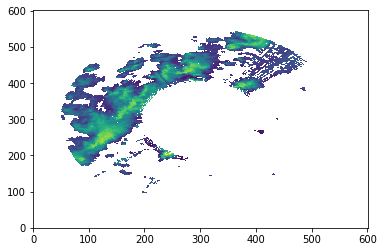

In [22]:
#Looking at a specific level and time of our data
plt.pcolormesh(all_xr_data['reflectivity'][5,5,:,:])
# plt.pcolormesh(maxrefl[2,:,:])

In [39]:
#QUICK COMPOSITE REFLECTIVITY HERE:
maxrefl = all_xr_data['reflectivity'].max(axis=1)

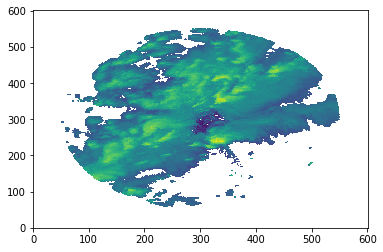

In [27]:
plt.pcolormesh(maxrefl[20,:,:])

In [32]:
# Setting projection and ploting the second tilt
proj = ccrs.PlateCarree()


Load in *tobac*

In [31]:
import tobac
import tobac.testing
import tobac.feature_detection
import tobac.segmentation

/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/iris/fileformats/_ff.py:819: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def _parse_binary_stream(file_like, dtype=np.float, count=-1):
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/pyke/knowledge_engine.py:28: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  f

In [33]:
feature_detection_params = dict()
feature_detection_params['threshold'] = [30]#, 40, 50]
feature_detection_params['target'] = 'maximum'
feature_detection_params['position_threshold'] = 'weighted_diff'
feature_detection_params['n_erosion_threshold'] = 2
feature_detection_params['sigma_threshold'] = 1
feature_detection_params['n_min_threshold'] = 4


Note that to track in 3D, we must give information about what our height coordinate is. Iris tends to be picky about the naming conventions, so we need to assign standard names as well.

In [34]:
xr_grid_full = all_xr_data['reflectivity']
xr_grid_full['z'] = all_xr_data.z.assign_attrs({'standard_name': 'altitude'})
xr_grid_full['lat'] = all_xr_data.lat.assign_attrs({'standard_name': 'latitude'})
xr_grid_full['lon'] = all_xr_data.lon.assign_attrs({'standard_name': 'longitude'})

In [51]:
#Even though we read in our data using Xarray, and Xarray is our data handler of choice (could also be Pandas)
#we need to conver this data to iris cubes. Future versions of tobac will be built on Xarray, but for now we convert.
grid_iris = xr_grid_full.to_iris()


In [68]:
#FURTHER, to use tobac we need to know the grid spacing in both x/y/z and time:
# #Dt, DXY
datetimes = xr_grid_full['time']
timedeltas = [(datetimes[i-1]-datetimes[i]).astype('timedelta64[m]') for i in range(1, len(datetimes))]
print(len(timedeltas))
average_timedelta = sum(timedeltas) / len(timedeltas)
dt = np.abs(np.array(average_timedelta)).astype('timedelta64[m]').astype(int)


deltax = [xr_grid_full['x'][i-1]-xr_grid_full['x'][i] for i in range(1, len(xr_grid_full['x']))]
dxy = np.abs(np.mean(deltax).astype(int))/1000


print(dxy,dt)

51
0.5 3


In [77]:
#I also want to define a save directory. 
#Set up directory to save output and plots:
savedir='tobac_Save'
if not os.path.exists(savedir):
    os.makedirs(savedir)
plot_dir=savedir+"/tobac_Plot"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

## We're going to start simple before getting more complicated: tracking in 2D

In [55]:
#Create a composite reflectivity to get started, turning our 3D reflectivity into 2D:
maxrefl = xr_grid_full.max(dim='z')

In [62]:
#Convert to iris:
maxrefl_iris = maxrefl.to_iris()

In [83]:
#FIND OUR FEATURES!

print('starting feature detection based on multiple thresholds')
Features_df = tobac.feature_detection_multithreshold(maxrefl_iris, dxy, **feature_detection_params)

Features=Features_df.to_xarray()
print('feature detection done')

Features.to_netcdf(os.path.join(savedir,'Features.nc'))
print('features saved')

starting feature detection based on multiple thresholds


/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/skimage/morphology/binary.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  out = np.empty(image.shape, dtype=np.bool)
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/skimage/morphology/binary.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  out = np.empt

feature detection done
features saved


In [84]:
Features

<xarray.Dataset>
Dimensions:                  (index: 2136)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 ... 2132 2133 2134 2135
Data variables: (12/13)
    frame                    (index) int64 0 0 0 0 0 0 0 ... 51 51 51 51 51 51
    idx                      (index) int64 1 2 3 8 9 10 11 ... 49 51 52 53 54 55
    hdim_1                   (index) float64 191.2 306.0 233.1 ... 438.9 470.3
    hdim_2                   (index) float64 217.8 132.8 187.9 ... 344.9 310.4
    num                      (index) int64 1068 9755 91 13 1777 ... 44 39 12 734
    threshold_value          (index) int64 30 30 30 30 30 30 ... 30 30 30 30 30
    ...                       ...
    time                     (index) object 2008-04-11 18:12:23 ... 2008-04-1...
    timestr                  (index) object '2008-04-11 18:12:23' ... '2008-0...
    projection_y_coordinate  (index) float64 -5.439e+04 2.993e+03 ... 8.515e+04
    projection_x_coordinate  (index) float64 -4.109e+04 -8.359e+04 ... 5.192e+03
    latitude                 (index) float64 34.15 34.66 34.33 ... 35.26 35.4
    longitude                (index) float64 -87.21 -87.67 ... -86.53 -86.72

In [72]:
# Dictionary containing keyword arguments for segmentation step:
parameters_segmentation={}
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']= 30 
#parameters_segmentation['features']
#parameters_segmentation['field']
#parameters_segmentation['dxy']
#parameters_segmentation['target']
#parameters_segmentation['level']
#parameters_segmentation['max_distance']
#Maximum distance from a marker allowed to be classified as
        #belonging to that cell. Default is None.
#parameters_segmentation['vertical_coord']

In [85]:
# Features_df=Features.to_dataframe()

# Perform Segmentation and save resulting mask to NetCDF file:
print('Starting segmentation based on reflectivity')
Mask_iris,Features_Precip =tobac.segmentation.segmentation(Features_df,maxrefl_iris,dxy,**parameters_segmentation)

Mask=xr.DataArray.from_iris(Mask_iris)
Mask = Mask.to_dataset()


#Mask,Features_Precip=segmentation(Features,maxrefl,dxy,**parameters_segmentation)
print('segmentation based on reflectivity performed, start saving results to files')
Mask.to_netcdf(os.path.join(savedir,'Mask_Segmentation_refl.nc'))                


Starting segmentation based on reflectivity
segmentation based on reflectivity performed, start saving results to files


In [87]:
# Dictionary containing keyword arguments for the linking step:
parameters_linking={}
parameters_linking['stubs'] = 3 #5
parameters_linking['method_linking']='predict'
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['extrapolate']=0
parameters_linking['order']=2 #Order of polynomial for extrapolating
parameters_linking['subnetwork_size']=100 
parameters_linking['memory']= 3#4
#parameters_linking['time_cell_min']=1
parameters_linking['v_max']=0.6 
parameters_linking['d_min']= None #5 

In [103]:
# Perform trajectory linking using trackpy and save the resulting DataFrame:

Track_df=tobac.linking_trackpy(Features_df,Mask_iris,dt=dt,dxy=dxy,**parameters_linking)

Track = Track_df.to_xarray()

Track.to_netcdf(os.path.join(savedir,'Track.nc'))

Frame 51: 50 trajectories present.


In [118]:
Features

<xarray.Dataset>
Dimensions:                  (index: 2136)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 ... 2132 2133 2134 2135
Data variables: (12/13)
    frame                    (index) int64 ...
    idx                      (index) int64 ...
    hdim_1                   (index) float64 ...
    hdim_2                   (index) float64 ...
    num                      (index) int64 ...
    threshold_value          (index) int64 ...
    ...                       ...
    time                     (index) datetime64[ns] ...
    timestr                  (index) object ...
    projection_y_coordinate  (index) float64 ...
    projection_x_coordinate  (index) float64 ...
    latitude                 (index) float64 ...
    longitude                (index) float64 ...

In [113]:
d = tobac.merge_split.merge_split_MEST(Track_df,500., distance=25000.0)


Track = xr.open_dataset(savedir+"/Track.nc")
# ds = tobac.utils.standardize_track_dataset(Track, refl_mask)#, data['ProjectionCoordinateSystem'])
# # ds = standardize_track_dataset(Track, refl_mask)#, data['ProjectionCoordinateSystem'])
# # both_ds = xarray.combine_by_coords((ds,d), compat='override')
# both_ds = xarray.merge([ds, d],compat ='override')

# from scipy.spatial import KDTree
# hdim1 = both_ds['feature_hdim1_coordinate'].values*0.5
# hdim2 = both_ds['feature_hdim2_coordinate'].values*0.5
# pts = np.vstack((hdim2, hdim1)).T
# tree = KDTree(pts)
# #note hdim is in km on the grid
# num_obj = np.zeros(len(both_ds["feature"].values))
# for i,ind in enumerate(both_ds["feature"].values):
#     num_obj[i]=len(tree.query_ball_point(pts[i],r=5))
# num_obj = num_obj.astype(int)
# both_ds = both_ds.assign(feature_nearby_count=(['feature'], num_obj))

# both_ds = tobac.utils.compress_all(both_ds)
# both_ds.to_netcdf(os.path.join(savedir,'Track_features_merges.nc'))

In [114]:
d

<xarray.Dataset>
Dimensions:                   (track: 36, cell: 53, feature: 2136)
Coordinates:
  * track                     (track) float64 0.0 1.0 2.0 3.0 ... 33.0 34.0 35.0
  * cell                      (cell) int64 -1 40 69 110 ... 1335 1336 1344 1356
  * feature                   (feature) int64 1 2 3 4 5 ... 2133 2134 2135 2136
Data variables:
    cell_parent_track_id      (cell) float64 0.0 1.0 2.0 3.0 ... 30.0 34.0 35.0
    feature_parent_cell_id    (feature) int64 -1 -1 -1 -1 -1 ... 1356 -1 -1 -1
    feature_parent_track_id   (feature) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0
    track_child_cell_count    (track) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    cell_child_feature_count  (cell) float64 1.967e+03 3.0 3.0 ... 3.0 3.0 3.0

In [109]:

Track = xr.open_dataset(savedir+"/Track.nc")
Features = xr.open_dataset(savedir+"/Features.nc")
refl_mask = xr.open_dataset(savedir+"/Mask_Segmentation_refl.nc")

# both_ds = xarray.open_dataset(savedir+'/Track_features_merges.nc')

In [63]:
Features

<xarray.Dataset>
Dimensions:                  (index: 2136)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 ... 2132 2133 2134 2135
Data variables: (12/13)
    frame                    (index) int64 0 0 0 0 0 0 0 ... 51 51 51 51 51 51
    idx                      (index) int64 1 2 3 8 9 10 11 ... 49 51 52 53 54 55
    hdim_1                   (index) float64 191.2 306.0 233.1 ... 438.9 470.3
    hdim_2                   (index) float64 217.8 132.8 187.9 ... 344.9 310.4
    num                      (index) int64 1068 9755 91 13 1777 ... 44 39 12 734
    threshold_value          (index) int64 30 30 30 30 30 30 ... 30 30 30 30 30
    ...                       ...
    time                     (index) object 2008-04-11 18:12:23 ... 2008-04-1...
    timestr                  (index) object '2008-04-11 18:12:23' ... '2008-0...
    projection_y_coordinate  (index) float64 -5.439e+04 2.993e+03 ... 8.515e+04
    projection_x_coordinate  (index) float64 -4.109e+04 -8.359e+04 ... 5.192e+03
    latitude                 (index) float64 34.15 34.66 34.33 ... 35.26 35.4
    longitude                (index) float64 -87.21 -87.67 ... -86.53 -86.72

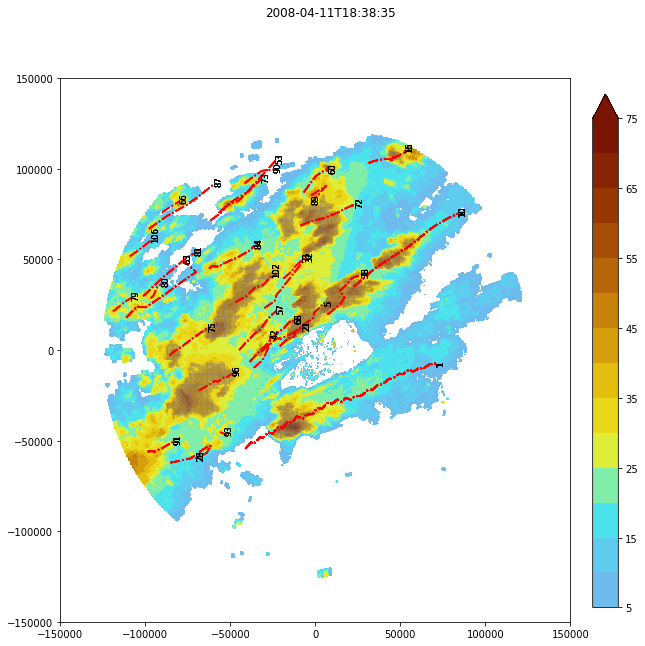

In [67]:
#
frame = 10
isolated_min = 0.5
show_tracks = True
ref_levels = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]

fig, ax = plt.subplots(figsize=(10,10))

refl = maxrefl[frame,:,:] 
fig.suptitle(str(maxrefl['time'][frame].data)[:-10])
y_mesh,x_mesh = np.meshgrid(maxrefl['x'],maxrefl['y'])
    
refplt = ax.contourf(y_mesh,x_mesh, refl, extend = 'max',levels = ref_levels,cmap='pyart_LangRainbow12',origin = 'lower', vmin=-24, vmax=72)#,extent = [0,-10000,-20000,-10000])
fig.colorbar(refplt,fraction=0.046, pad=0.04)
i = np.where(Mask['segmentation_mask'][frame,:,:] > 0)
    

y, x = y_mesh[i[0],i[1]],x_mesh[i[0],i[1]]
imcell2 = ax.scatter(y,x,s = 0.1,c = 'gray', marker = '.',alpha = 0.75)
    


for i in Track['cell']:
    if i < 0:
        continue
    #print(i)
    if math.isfinite(i):
        cell_i = np.where(d['feature_parent_cell_id'] == i)
        if (np.nanmax(Features['frame'][cell_i]) >= frame) and (np.nanmin(Features['frame'][cell_i]) <= frame):
            ax.plot(Track['projection_x_coordinate'][cell_i], Track['projection_y_coordinate'][cell_i], '-.',color='r')
            ax.text(Track['projection_x_coordinate'][cell_i][-1],Track['projection_y_coordinate'][cell_i][-1], f'{int(i)}', fontsize = 'small',rotation = 'vertical')
        else:
            continue
 





#     fig.savefig(plot_dir+'/'+'20260331_track_'+str(frame)+'.png')




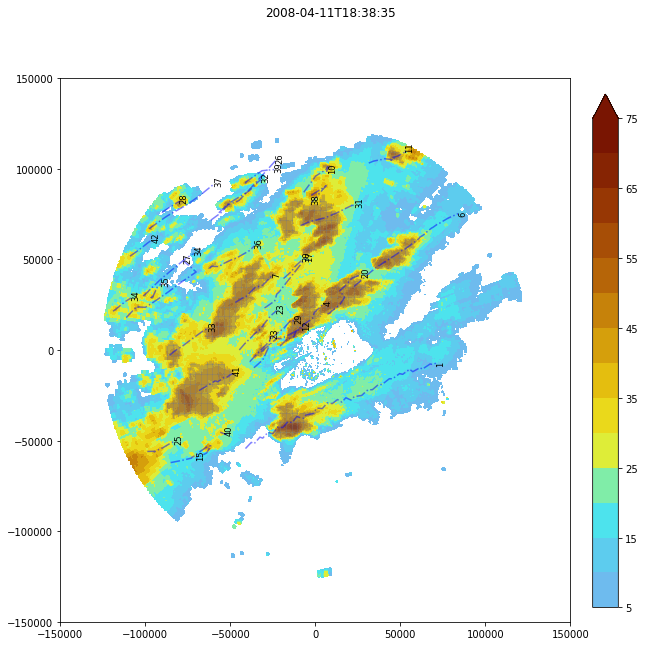

In [68]:
#
frame = 10
isolated_min = 0.5
show_tracks = True
ref_levels = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]

fig, ax = plt.subplots(figsize=(10,10))

refl = maxrefl[frame,:,:] 
fig.suptitle(str(maxrefl['time'][frame].data)[:-10])
y_mesh,x_mesh = np.meshgrid(maxrefl['x'],maxrefl['y'])
    
refplt = ax.contourf(y_mesh,x_mesh, refl, extend = 'max',levels = ref_levels,cmap='pyart_LangRainbow12',origin = 'lower', vmin=-24, vmax=72)#,extent = [0,-10000,-20000,-10000])
fig.colorbar(refplt,fraction=0.046, pad=0.04)
i = np.where(Mask['segmentation_mask'][frame,:,:] > 0)
    

y, x = y_mesh[i[0],i[1]],x_mesh[i[0],i[1]]
imcell2 = ax.scatter(y,x,s = 0.1,c = 'gray', marker = '.',alpha = 0.75)
    



for i in d['track']:
    track_i = np.where(d['cell_parent_track_id'] == i.values)
    for cell in d['cell'][track_i]:
        if cell < 0:
            continue

        feature_id = np.where(d['feature_parent_cell_id'] == cell)
        if (frame <= np.nanmax(Features['frame'][feature_id])) and (frame >= np.nanmin(Features['frame'][feature_id])):
            ax.plot(Track['projection_x_coordinate'][feature_id], Track['projection_y_coordinate'][feature_id], '-.',color='b',alpha = 0.5)
            ax.text(Track['projection_x_coordinate'][feature_id][-1],Track['projection_y_coordinate'][feature_id][-1], f'{int(i)}', fontsize = 'small',rotation = 'vertical')
        else:
            continue





#     fig.savefig(plot_dir+'/'+'20260331_track_'+str(frame)+'.png')


